# DB2 Data Cleaning

## Introduction

In this project, we aim to predict the performance of database transfers based on various system and transfer-related parameters. We utilize performance benchmark datasets from nine different experiments to train and evaluate several machine learning models. The target variable for our prediction is the `TotaltransferTime`.

The steps involved in this project are as follows:
1. **Data Loading and Concatenation**: Load performance data from nine experiments and concatenate them into a single DataFrame.
2. **Feature Engineering**: Aggregate relevant table statistics and add them to the main DataFrame.
3. **Data Cleaning**: Remove duplicate rows and handle missing values.
4. **Data Visualization**: Visualize data to understand correlations and distributions.
5. **Data Preprocessing**: Create preprocessing pipelines for numerical and categorical data.
6. **Model Selection and Training**: Train multiple machine learning models and evaluate their performance.

## 1. Data Loading and Concatenation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


In [3]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [4]:
# Load the performance benchmark datasets
exp1_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp1/performanceBenchmark.csv')
exp2_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp2/performanceBenchmark.csv')
exp3_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp3/performanceBenchmark.csv')
exp4_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp4/performanceBenchmark.csv')
exp5_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp5/performanceBenchmark.csv')
exp6_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp6/performanceBenchmark.csv')
exp7_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp7/performanceBenchmark.csv')
exp8_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp8/performanceBenchmark.csv')
exp9_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp9/performanceBenchmark.csv')

In [5]:
exp1_performance_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN


Concatenating all the experiments

In [6]:
performance_dfs = [exp1_performance_df, exp2_performance_df, exp3_performance_df, 
                   exp4_performance_df, exp5_performance_df, exp6_performance_df, 
                   exp7_performance_df, exp8_performance_df, exp9_performance_df]

performance_df = pd.concat(performance_dfs, ignore_index=True)

In [7]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               140 non-null    int64  
 1   compress                        140 non-null    object 
 2   sourceDatabasetoTargetDatabase  140 non-null    object 
 3   tables                          140 non-null    object 
 4   maxStreams                      140 non-null    int64  
 5   binary                          140 non-null    bool   
 6   Experiment startTime            140 non-null    float64
 7   TotalExperimentTime             140 non-null    float64
 8   TotaltransferTime               140 non-null    float64
 9   totalPrecheckTime               140 non-null    float64
 10  TotalClearTime                  97 non-null     float64
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 11.2+ KB


The `calculate_table_sums` function calculates and aggregates the total data size, number of rows, and number of columns for specified table names within a dataframe. It adds these aggregated values as new features to the original dataframe.

## 2. Feature Engineering
We define a function `calculate_table_sums` to calculate and aggregate the total data size, number of rows, and number of columns for specified table names within the DataFrame.


In [8]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    exp_df = exp_df[['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime', 'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime']]

    return exp_df

In [9]:
performance_df = calculate_table_sums(performance_df, tables_df)

[] [] []


In [10]:
performance_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', 'Experiment startTime'], axis=1, inplace=True)

In [11]:
performance_df.head(10)

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime
0,NO,2774,20887909,34,1,False,3266.620216
1,NO,2774,20887909,34,1,False,588.320576
2,NO,2774,20887909,34,1,False,1920.935266
3,NO,2774,20887909,34,1,False,3783.924402
4,NO,2774,20887909,34,1,False,1901.642637
5,GZIP,2774,20887909,34,1,False,928.459119
6,GZIP,2774,20887909,34,1,False,4838.436518
7,GZIP,2774,20887909,34,1,False,3387.124010
8,GZIP,2774,20887909,34,1,False,2479.712331
9,GZIP,2774,20887909,34,1,False,2414.547340


In [12]:
# Concatenate the experiment tables with the system specs
df2_repeated = pd.concat([source_machine_df]*len(performance_df), ignore_index=True)


result_df = pd.concat([performance_df, df2_repeated], axis=1)


In [13]:
result_df.head()

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576


## 3. Data Cleaning

### 3.1 Check for duplicate rows and remove them if any.


In [14]:
result_df.duplicated().sum()

4

In [15]:
result_df.drop_duplicates()

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...
132,NO,5337,15000000,27,10,False,320.256194,120,16,20,576
133,NO,5337,15000000,27,10,False,308.434418,120,16,20,576
134,NO,5337,15000000,27,10,False,322.706327,120,16,20,576
135,NO,23589,165000000,99,10,False,11094.895988,120,16,20,576


### 3.2 Handle the missing values


In [16]:
result_df.isna().sum()

compress                 0
Data size sum (MB)       0
Number of rows sum       0
Number of columns sum    0
maxStreams               0
binary                   0
TotaltransferTime        0
RAM (GB)                 0
CPU                      0
Disk (GB)                0
External Disk (GB)       0
dtype: int64

In [17]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...
135,NO,23589,165000000,99,10,False,11094.895988,120,16,20,576
136,NO,23589,165000000,99,10,False,0.000000,120,16,20,576
137,NO,23589,165000000,99,10,False,0.000000,120,16,20,576
138,NO,23589,165000000,99,10,False,0.000000,120,16,20,576


In [18]:
result_df = result_df.drop(result_df[result_df['TotaltransferTime'] == 0].index)


In [19]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...
131,NO,5337,15000000,27,10,False,259.839403,120,16,20,576
132,NO,5337,15000000,27,10,False,320.256194,120,16,20,576
133,NO,5337,15000000,27,10,False,308.434418,120,16,20,576
134,NO,5337,15000000,27,10,False,322.706327,120,16,20,576


In [20]:
print(result_df['TotaltransferTime'].tolist())

[3266.620215892792, 588.3205764293671, 1920.9352657794952, 3783.92440199852, 1901.6426374912264, 928.4591188430786, 4838.436517715454, 3387.12401008606, 2479.7123305797577, 2414.547339916229, 4576.687717199326, 978.3304245471954, 379.8497135639191, 787.3973054885864, 1411.3418102264404, 3475.7842950820923, 2809.898271560669, 2524.281928300857, 2403.7056925296783, 2876.231304883957, 2815.140542984009, 2325.539189815521, 2608.7671797275543, 2485.299339056015, 2393.734699010849, 2612.2335081100464, 105.9590163230896, 1645.611917734146, 83.76851081848145, 7787.086072444916, 5556.246872186661, 9359.070492506027, 7190.761970043182, 5178.868355989456, 19236.447966575623, 19425.01243019104, 274.36430501937866, 201.5299296379089, 226.23644495010376, 223.03668642044067, 237.3107452392578, 1224.2546446323397, 423.74039125442505, 347.0640170574188, 1055.5288627147677, 408.11474442482, 363.38030886650085, 4765.051084280014, 5104.31724691391, 3588.668117284775, 570.1276996135712, 283.3432488441468, 

In [21]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 0 to 135
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               131 non-null    object 
 1   Data size sum (MB)     131 non-null    int64  
 2   Number of rows sum     131 non-null    int64  
 3   Number of columns sum  131 non-null    int64  
 4   maxStreams             131 non-null    int64  
 5   binary                 131 non-null    bool   
 6   TotaltransferTime      131 non-null    float64
 7   RAM (GB)               131 non-null    int64  
 8   CPU                    131 non-null    int64  
 9   Disk (GB)              131 non-null    int64  
 10  External Disk (GB)     131 non-null    int64  
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 11.4+ KB


## 4. Visualizing the Data

### 4.1 Correlation Matrix using Pearson correlation coefficient


In [22]:
# Calculate the correlation matrix
corr_matrix = result_df.corr(numeric_only=True)
corr_matrix

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
Data size sum (MB),1.000000,0.959581,0.843968,0.166968,NaN,0.707766,NaN,NaN,NaN,NaN
Number of rows sum,0.959581,1.000000,0.830751,0.147800,NaN,0.736415,NaN,NaN,NaN,NaN
Number of columns sum,0.843968,0.830751,1.000000,0.141505,NaN,0.647122,NaN,NaN,NaN,NaN
maxStreams,0.166968,0.147800,0.141505,1.000000,NaN,-0.221160,NaN,NaN,NaN,NaN
binary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotaltransferTime,0.707766,0.736415,0.647122,-0.221160,NaN,1.000000,NaN,NaN,NaN,NaN
RAM (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
External Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.2 Correlation with regard to the target "Total Transfer Time"


In [23]:
corr_matrix["TotaltransferTime"].sort_values(ascending=False)

TotaltransferTime        1.000000
Number of rows sum       0.736415
Data size sum (MB)       0.707766
Number of columns sum    0.647122
maxStreams              -0.221160
binary                        NaN
RAM (GB)                      NaN
CPU                           NaN
Disk (GB)                     NaN
External Disk (GB)            NaN
Name: TotaltransferTime, dtype: float64

### 4.3 Histogram


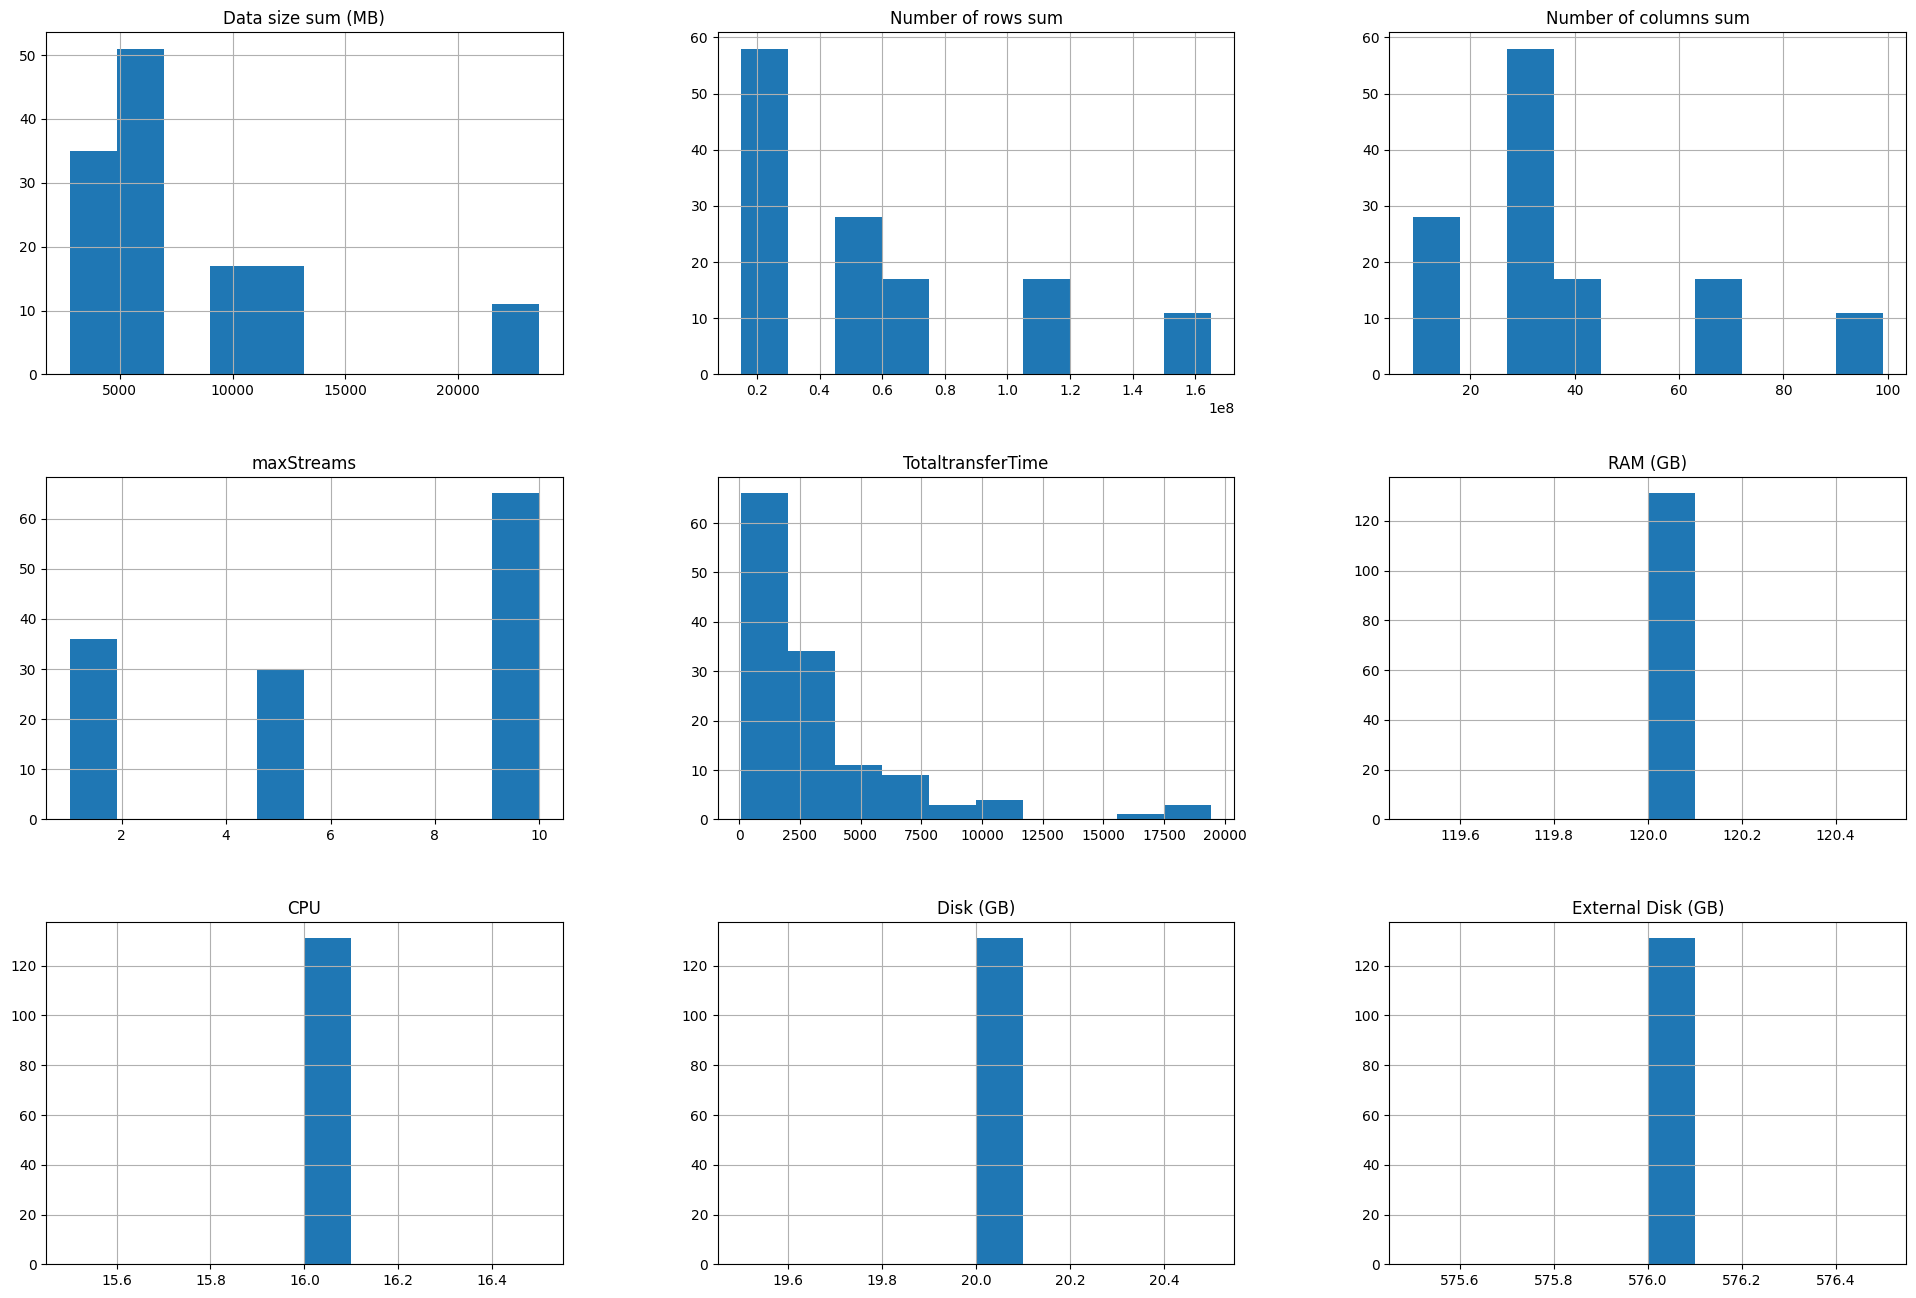

In [24]:
result_df.hist(figsize=(24, 16))
plt.show()

### 4.4 Pairwise correlation using seaborn


In [25]:
# Uncomment to generate pairplot (disabled for performance reasons)

# sns.pairplot(result_df)

## 5. Preprocessing

### 5.1 Create a pipeline


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [27]:
# Separate numerical and categorical columns
num_cols = result_df.select_dtypes(include='number').columns.to_list()
cat_cols = result_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [28]:
# Display the pipeline
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Data size sum (MB)', 'Number of rows sum',
                                  'Number of columns sum', 'maxStreams',
                                  'RAM (GB)', 'CPU', 'Disk (GB)',
                                  'External Disk (GB)']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['compress', 'binary'])])

In [29]:
# Apply the preprocessing pipeline on the dataset
result_df_prepared = preprocessing.fit_transform(result_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,num__maxStreams,num__RAM (GB),num__CPU,num__Disk (GB),num__External Disk (GB),cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,remainder__TotaltransferTime
0,-0.873887,-0.728844,-0.118917,-1.394550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3266.620216
1,-0.873887,-0.728844,-0.118917,-1.394550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,588.320576
2,-0.873887,-0.728844,-0.118917,-1.394550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1920.935266
3,-0.873887,-0.728844,-0.118917,-1.394550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3783.924402
4,-0.873887,-0.728844,-0.118917,-1.394550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1901.642637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,-0.436154,-0.862067,-0.405130,0.937613,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,259.839403
127,-0.436154,-0.862067,-0.405130,0.937613,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,320.256194
128,-0.436154,-0.862067,-0.405130,0.937613,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,308.434418
129,-0.436154,-0.862067,-0.405130,0.937613,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,322.706327


## 6. Selecting Model and Training

### 6.1 Split the dataset into a training dataset (80%) and testing dataset (20%).


In [30]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = result_df_prepared.drop(["remainder__TotaltransferTime"], axis=1)
y = result_df_prepared["remainder__TotaltransferTime"]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(104, 12) (104,) (27, 12) (27,)


### 6.2 Define a function to report regression metrics


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    report = {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

    for metric, value in report.items():
        print(f"{metric}: {value:.4f}")

    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

### 6.3 Train and Evaluate Models

We will train and evaluate several models, including Decision Tree, Random Forest, Gradient Boosting, and XGBoost.

#### Decision Tree Regressor

In [32]:
# Dictionary to store the reports
reports = {}
feature_importances = {}

In [33]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Regressor Report:")
reports["Decision Tree"] = regression_report(y_test, y_pred_dt)
# Pad the Decision Tree feature importances to match feature length
dt_importances = np.zeros(len(feature_names))
dt_importances[:len(dt_model.feature_importances_)] = dt_model.feature_importances_
feature_importances["Decision Tree"] = dt_importances

Decision Tree Regressor Report:
Mean Absolute Error (MAE): 879.1466
Mean Squared Error (MSE): 3385455.3281
Root Mean Squared Error (RMSE): 1839.9607
R² Score: 0.7940


#### Random Forest Regressor


In [34]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Regressor Report:")
reports["Random Forest"] = regression_report(y_test, y_pred_rf)
# Pad the Random Forest feature importances to match feature length
rf_importances = np.zeros(len(feature_names))
rf_importances[:len(rf_model.feature_importances_)] = rf_model.feature_importances_
feature_importances["Random Forest"] = rf_importances

Random Forest Regressor Report:
Mean Absolute Error (MAE): 871.4569
Mean Squared Error (MSE): 3186668.1916
Root Mean Squared Error (RMSE): 1785.1241
R² Score: 0.8061


#### Gradient Boosting Regressor


In [35]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Regressor Report:")
reports["Gradient Boosting"] = regression_report(y_test, y_pred_gb)
# Pad the Gradient Boosting feature importances to match feature length
gb_importances = np.zeros(len(feature_names))
gb_importances[:len(gb_model.feature_importances_)] = gb_model.feature_importances_
feature_importances["Gradient Boosting"] = gb_importances

Gradient Boosting Regressor Report:
Mean Absolute Error (MAE): 917.9932
Mean Squared Error (MSE): 3517650.4339
Root Mean Squared Error (RMSE): 1875.5400
R² Score: 0.7860


#### XGBoost Regressor


In [36]:
# XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Regressor Report:")
reports["XGBoost"] = regression_report(y_test, y_pred_xgb)
# Pad the XGBoost feature importances to match feature length
xgb_importances = np.zeros(len(feature_names))
xgb_importances[:len(xgb_model.feature_importances_)] = xgb_model.feature_importances_
feature_importances["XGBoost"] = xgb_importances

XGBoost Regressor Report:
Mean Absolute Error (MAE): 879.1460
Mean Squared Error (MSE): 3385456.7154
Root Mean Squared Error (RMSE): 1839.9611
R² Score: 0.7940


### 6.4 Summary of Model Performance

Convert the reports dictionary to a DataFrame and display the results.


In [37]:
# Convert the reports dictionary to a DataFrame
reports_df = pd.DataFrame.from_dict(reports, orient='index')
print(reports_df)

# Save the DataFrame to a CSV file
reports_df.to_csv("model_performance_reports.csv", index=True)

                   Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
Decision Tree                     879.146646              3.385455e+06   
Random Forest                     871.456868              3.186668e+06   
Gradient Boosting                 917.993236              3.517650e+06   
XGBoost                           879.146002              3.385457e+06   

                   Root Mean Squared Error (RMSE)  R² Score  
Decision Tree                         1839.960687  0.794030  
Random Forest                         1785.124139  0.806124  
Gradient Boosting                     1875.540038  0.785987  
XGBoost                               1839.961064  0.794030  


### 6.5 Feature Importances

Visualize the feature importances for each model.


In [38]:
# Save feature importances to a CSV file
feature_importances_df = pd.DataFrame(feature_importances, index=feature_names)
print(feature_importances_df)

# Save the DataFrame to a CSV file
feature_importances_df.to_csv("feature_importances.csv", index=True)

                              Decision Tree  Random Forest  Gradient Boosting  \
num__Data size sum (MB)            0.103472       0.205493           0.247836   
num__Number of rows sum            0.004081       0.226522           0.243056   
num__Number of columns sum         0.580480       0.255419           0.186310   
num__maxStreams                    0.282753       0.278312           0.281022   
num__RAM (GB)                      0.000000       0.000000           0.000000   
num__CPU                           0.000000       0.000000           0.000000   
num__Disk (GB)                     0.000000       0.000000           0.000000   
num__External Disk (GB)            0.000000       0.000000           0.000000   
cat__compress_GZIP                 0.000012       0.006534           0.009443   
cat__compress_LZ4                  0.008540       0.011524           0.012905   
cat__compress_NO                   0.020663       0.016196           0.019429   
cat__binary_False           

In [39]:
reports_df

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R² Score
Decision Tree,879.146646,3.385455e+06,1839.960687,0.794030
Random Forest,871.456868,3.186668e+06,1785.124139,0.806124
Gradient Boosting,917.993236,3.517650e+06,1875.540038,0.785987
XGBoost,879.146002,3.385457e+06,1839.961064,0.794030


In [40]:
feature_importances_df

,Decision Tree,Random Forest,Gradient Boosting,XGBoost
num__Data size sum (MB),0.103472,0.205493,0.247836,0.406533
num__Number of rows sum,0.004081,0.226522,0.243056,0.049206
num__Number of columns sum,0.580480,0.255419,0.186310,0.373611
num__maxStreams,0.282753,0.278312,0.281022,0.128994
num__RAM (GB),0.000000,0.000000,0.000000,0.000000
num__CPU,0.000000,0.000000,0.000000,0.000000
num__Disk (GB),0.000000,0.000000,0.000000,0.000000
num__External Disk (GB),0.000000,0.000000,0.000000,0.000000
cat__compress_GZIP,0.000012,0.006534,0.009443,0.009062
cat__compress_LZ4,0.008540,0.011524,0.012905,0.032518
